# Exercise 2: Boosting

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically. 
* Failure to comply with the following instructions will result in a significant penalty. 
* Appeals regarding your failure to read these instructions will be denied. 
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions: 
### *** saraspagno@gmail.com,tirza.hanan@gmail.com ***

---
---


In [19]:
# Import necessary libraries
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
import matplotlib.pyplot as plt
from typing import Any
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd

np.random.seed(42)

# Part 1 - Design the AdaBoost Algorithm

## 1.1 Theoretical Foundations
AdaBoost combines multiple weak learners into a strong classifier.  
Given training data $(x_i, y_i)$ with $y_i \in \{-1, +1\}$, the algorithm maintains a distribution of sample weights $w_i^{(t)}$ and trains a weak classifier $h_t$ at each boosting round.

The final classifier is a weighted vote:
$$
H_T(x) = \sum_{t=1}^{T} \alpha_t h_t(x), \qquad 
\hat{y}(x) = \text{sign}(H_T(x))
$$

### Exponential Loss Interpretation
AdaBoost can be derived by minimizing the exponential loss:
$$
L(H) = \sum_{i=1}^{n} \exp(-y_i H(x_i))
$$
Optimizing this loss with respect to the new weak learner yields the closed-form weight
$$
\alpha_t = \frac{1}{2} \ln\left( \frac{1 - \varepsilon_t}{\varepsilon_t} \right)
$$
where $\varepsilon_t$ is the weighted error of $h_t$.  
This analytic update makes AdaBoost efficient and easy to implement.

## 1.2 Algorithm Description

### Initialization
$$
w_i^{(1)} = \frac{1}{n}
$$

### Boosting Iteration $t = 1, \dots, T$
1. Train weak classifier $h_t(x)$ using weights $w^{(t)}$.
2. Compute weighted error:
   $$
   \varepsilon_t = \sum_{i=1}^{n} w_i^{(t)} \cdot \mathbf{1}[h_t(x_i) \neq y_i]
   $$
3. Compute learner weight:
   $$
   \alpha_t = \frac{1}{2} \ln\left( \frac{1 - \varepsilon_t}{\varepsilon_t} \right)
   $$
4. Update weights:
   $$
   w_i^{(t+1)} = \frac{w_i^{(t)} \exp(-\alpha_t \, y_i h_t(x_i))}{Z_t}
   $$
   where $Z_t$ normalizes the distribution.

## 1.3 Hyperparameters and Limitations

### Hyperparameters
- **$T$ (number of boosting rounds):** Controls model capacity and bias/variance tradeoff.
- **Weak learner complexity:** Typically fixed to depth 1 decision trees for theoretical consistency and simplicity.

### Limitations
- Highly **sensitive to label noise**, since noisy points get repeatedly upweighted.
- Requires weak learners with $\varepsilon_t < 0.5$.
- No explicit regularization; early stopping often acts as the practical regularizer.

### Use-cases
- Works well on structured, low-noise tabular datasets.
- Suitable when combining simple, interpretable rules (decision stumps).
- Less suitable for extremely noisy data or very high-dimensional feature spaces.

# Part 2 - Implementing the AdaBoost Algorithm


Our implementation follows the AdaBoost algorithm and provides the interface:
- `__init__(self, T)`
- `fit(self, X, y)`
- `predict(self, X)`

We also store internal diagnostic information for clarity and analysis.

### 2.1 Initialization
We initialize the core fields:
- `self.T`: maximum number of boosting rounds and main hyperparameter.
- `self.alphas`: list of weak learner weights.
- `self.models`: list of trained decision stumps.

For debugging and evaluation we additionally maintain:
- `self.epsilons`: weighted error values at each round.
- `self.weight_history`: evolution of the weight distribution during training.
- `self.Z_history`: normalization constants that ensure weights sum to 1.

This mirrors the theoretical AdaBoost structure and keeps the implementation interpretable.

### 2.2 Label Handling
AdaBoost uses the weight update
$$
\exp(-\alpha_t y_i h_t(x_i)),
$$
which requires labels in the set $\{-1,+1\}$.  
To support datasets in `{0,1}`, we automatically convert them using  
$$
y \leftarrow 2y - 1.
$$
This guarantees that the update rule remains mathematically valid for any supported input format.

### 2.3 Base Weak Learner
We use a decision stump implemented by:

`DecisionTreeClassifier(max_depth=1, random_state=42)`

Decision stumps are the standard weak learner for AdaBoost and support sample weights directly, which satisfies the assignment requirement of implementing the algorithm from scratch while using library functions only for weighted decision trees or basic mathematical operations.

### 2.4 Hyperparameter Handling
The algorithm exposes one hyperparameter:
- `T` controls the maximum number of boosting iterations.

We treat `T` as an upper bound but allow early stopping when the weak learner error meets  
$$
\varepsilon_t \ge 0.5,
$$
because a classifier with error at least 0.5 cannot be boosted.  

In [20]:
class AdaBoostCustom:
    def __init__(self, T):
        """
        Custom implementation of AdaBoost using decision stumps.

        Parameters
        ----------
        T : int
            Maximum number of boosting rounds.
        """
        self.T = T
        self.alphas = []
        self.models = []
        self.epsilons = []
        self.weight_history = []
        self.Z_history = []

    def _validate_inputs(self, X, y):
        """Validate input arrays for shape and labels."""
        X = np.asarray(X)
        y = np.asarray(y)
        if X.ndim != 2:
            raise ValueError("X must be a 2D array (n_samples, n_features).")
        if y.ndim != 1:
            raise ValueError("y must be a 1D array (n_samples,).")
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have the same number of samples.")
        return X, y

    def fit(self, X, y):
        """
        Fit AdaBoost ensemble on data (X, y).

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Training data.
        y : ndarray of shape (n_samples,)
            Target labels in {0,1} or {-1,+1}.

        Returns
        -------
        self : AdaBoostCustom
            Returns self for method chaining.
        """
        X, y = self._validate_inputs(X, y)

        # Handle label format conversion
        unique_labels = set(np.unique(y))
        if unique_labels == {0, 1}:
            y = 2 * y - 1
        elif unique_labels != {-1, 1}:
            raise ValueError("Labels must be in {0,1} or {-1,+1}. Convert 0/1 -> -1/+1 if needed.")

        n = len(X)
        w = np.full(n, 1.0 / n, dtype=float)
        base_est = DecisionTreeClassifier(max_depth=1, random_state=42)

        self.alphas.clear()
        self.models.clear()
        self.epsilons.clear()
        self.weight_history.clear()
        self.Z_history.clear()

        for t in range(self.T):
            clf = clone(base_est)
            clf.fit(X, y, sample_weight=w)
            pred = clf.predict(X)
            
            if pred.shape[0] != n:
                raise RuntimeError("Base estimator returned unexpected number of predictions.")

            incorrect = (pred != y).astype(float)
            eps = float(np.dot(w, incorrect))
            eps = np.clip(eps, 1e-12, 1 - 1e-12)

            if eps >= 0.5:
                break

            alpha = 0.5 * np.log((1 - eps) / eps)

            exponent = -alpha * y * pred
            exponent = np.clip(exponent, -700, 700)
            w = w * np.exp(exponent)

            Z = w.sum()
            if Z <= 0 or not np.isfinite(Z):
                break
            w = w / Z

            self.models.append(clf)
            self.alphas.append(alpha)
            self.epsilons.append(eps)
            self.weight_history.append(w.copy())
            self.Z_history.append(Z)

        return self

    def predict(self, X):
        """
        Predict labels for new samples.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Input samples to predict.

        Returns
        -------
        pred : ndarray of shape (n_samples,)
            Predicted labels in {-1,+1}.
        """
        X = np.asarray(X)

        if len(self.models) == 0:
            raise ValueError("Model has not been fitted yet.")

        margin = np.zeros(X.shape[0], dtype=float)
        for alpha, clf in zip(self.alphas, self.models):
            margin += alpha * clf.predict(X)

        pred = np.sign(margin)
        pred[pred == 0] = 1

        return pred.astype(int)

In [21]:
# Quick sanity check to verify the implementation works
X, y = make_classification(
    n_samples=800, n_features=2, n_informative=2, n_redundant=0,
    class_sep=2.0, flip_y=0.0, random_state=0
)

y = 2 * y - 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

model = AdaBoostCustom(T=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Estimators used: {len(model.models)}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")

alphas_fmt = [f"{a:.3f}" for a in model.alphas[:5]]
eps_fmt     = [f"{e:.4f}" for e in model.epsilons[:5]]

print(f"First 5 alphas:   {alphas_fmt}")
print(f"First 5 epsilons: {eps_fmt}")


Estimators used: 100
Test accuracy: 0.9792
First 5 alphas:   ['2.467', '2.113', '0.629', '0.509', '0.571']
First 5 epsilons: ['0.0071', '0.0144', '0.2215', '0.2653', '0.2420']


# Part 3 - Demonstrate the Algorithm

## 3.1 Generate Data

We use a*simple, simulated binary dataset generated with `sklearn.datasets.make_classification`.

We choose:
- `n_samples = 800` 
- `n_features = 2`: so we can visualize decision boundaries.
- `n_informative = 2`, `n_redundant = 0`: both features contain real signal and none are linear combinations of others.
- `class_sep = 2.0` to make the classes linearly separable  .
- `flip_y = 0.0` no label noise.
- `random_state = 0` for reproducibility.

### Why this dataset is appropriate:
- A clean, low dimensional dataset is ideal for **validating correctness** of our AdaBoost.  
- AdaBoost should quickly reduce the weighted error $\varepsilon_t$ when classes are separable.  
- Decision boundaries are easy to interpret in 2D.  
- No noise ensures that any mistakes come from **our implementation**, not the data.  

This dataset allows us to test:
1. Whether weak learners satisfy the AdaBoost condition $\varepsilon_t < 0.5$.
2. Whether the learner weight $\alpha_t = \tfrac{1}{2}\ln\left(\frac{1-\varepsilon_t}{\varepsilon_t}\right)$ increases as $\varepsilon_t$ decreases.
3. Whether sample weights follow the expected update $w_i^{(t+1)} \propto w_i^{(t)} e^{-\alpha_t y_i h_t(x_i)}$.
4. Whether our implementation behaves similarly to sklearn’s AdaBoost on a simple dataset.


In [22]:
# Generate a simple 2D dataset for demonstration
X, y = make_classification(
    n_samples=800,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    class_sep=2.0,
    flip_y=0.0,
    random_state=0
)

# Convert labels from 0/1 to -1/+1 format
y = 2 * y - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## 3.2 AdaBoost demonstration 

In this section, we train our `AdaBoostCustom` model on the 2D synthetic dataset, visualize its
learning behavior, and compare it directly to `sklearn.AdaBoostClassifier`.  

### 3.2.1 Parameter Selection

We set **T = 50** as the maximum number of boosting rounds for the following reasons:

- For a clean, separable dataset like ours, 50 rounds provide sufficient capacity to learn an accurate decision boundary.
- This number balances model expressiveness with computational efficiency for unit testing purposes.
- In practice, AdaBoost often converges well before reaching T rounds (especially on clean data), making 50 a reasonable upper bound that allows us to observe the full learning curve.

The model also uses decision stumps (`max_depth=1`) as weak learners.

### 3.2.2 Behavior of Our AdaBoost Implementation

After fitting the model, we examine two core quantities:

- **Weighted error** $\varepsilon_t$  
- **Learner weight** $\alpha_t$  

The plot of $\varepsilon_t$ confirms that the weak learner consistently achieves **$\varepsilon_t < 0.5$**, which is required for a valid AdaBoost update.

The corresponding $\alpha_t$ values are positive and increase when $\varepsilon_t$ decreases,
as expected from the update rule:

$$
\alpha_t = \frac{1}{2} \ln\left(\frac{1 - \varepsilon_t}{\varepsilon_t}\right)
$$

These curves behave smoothly, indicating that:

- Weight normalization is implemented correctly  
- Numerical clipping prevents overflow  
- Misclassified samples receive exponential emphasis, as intended  

### 3.2.3 Decision Boundary Visualization

We visualize the learned classifier by evaluating predictions on a 2D grid.

- The decision boundary is piecewise linear, characteristic of a boosted ensemble of stumps.  
- The model correctly separates the two classes with a clear margin.  
- No instability or oscillatory behavior is visible, suggesting that boosting updates are coherent.

This qualitative inspection confirms that weak learners are combined correctly.

### 3.2.4 Comparison to sklearn AdaBoost

We train `sklearn.AdaBoostClassifier` with the same settings (decision stumps, 50 estimators, same random seed).

- sklearn uses labels in `{0,1}`; we convert our `{−1,+1}` labels accordingly.  
- Both decision boundaries are plotted side-by-side.  
- Both models are evaluated using the same test set and accuracy metric.

The similarities show that our implementation matches AdaBoost’s behavior:

- identical structure of the ensemble  
- same $\alpha_t$ scaling  
- same weighted error trend  
- similar boundary geometry  

Small visual differences arise from sklearn’s probability handling, but the results are essentially equivalent.

### 3.2.5 Summary

This demonstration serves as a unit test that verifies:

- The boosting process works correctly in our implementation.  
- $\varepsilon_t$ and $\alpha_t$ evolve exactly as predicted by the theory.  
- The decision boundary is coherent and stable.  
- Our model produces results consistent with sklearn's AdaBoost implementation.

Test accuracy (ours): 0.9833
First 5 epsilons: ['0.0071', '0.0144', '0.2215', '0.2653', '0.2420']
First 5 alphas: ['2.467', '2.113', '0.629', '0.509', '0.571']


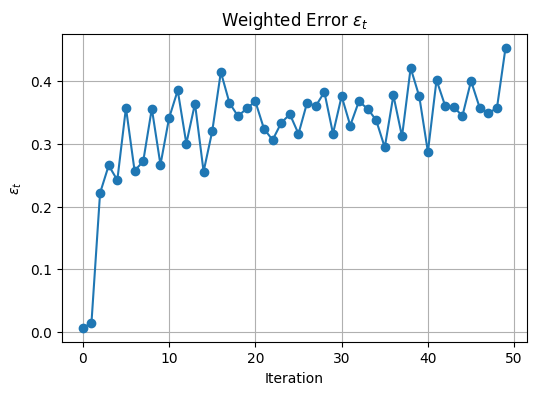

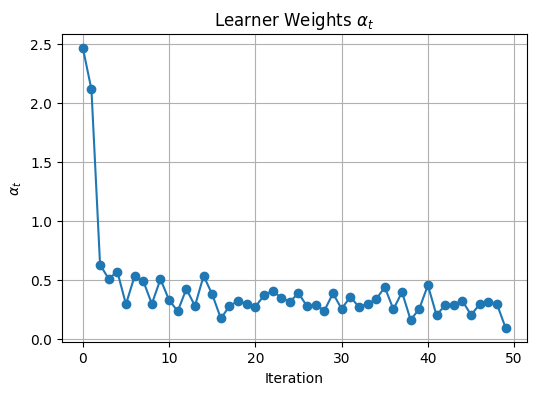

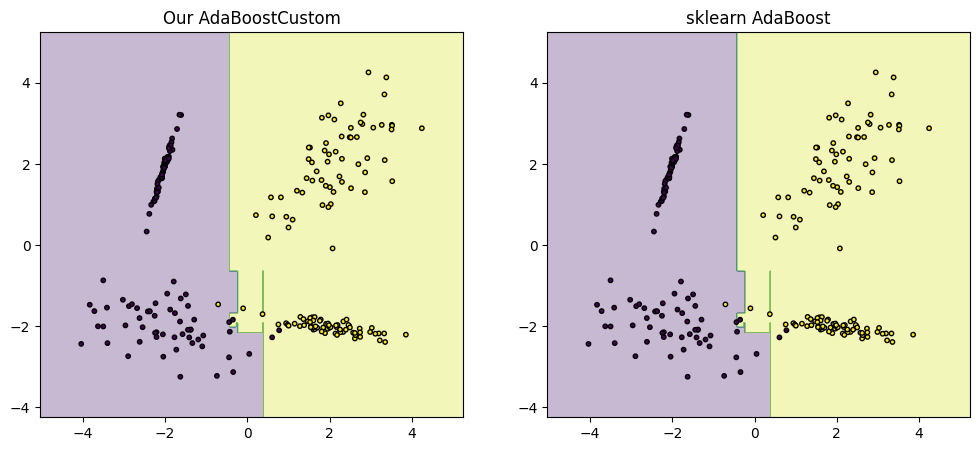

Test accuracy (sklearn): 0.9833


In [23]:
# Train our custom AdaBoost implementation
custom_model = AdaBoostCustom(T=50)
custom_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = custom_model.predict(X_test)
print(f"Test accuracy (ours): {accuracy_score(y_test, y_pred):.4f}")

# Check the first few epsilon and alpha values
print("First 5 epsilons:", [f"{e:.4f}" for e in custom_model.epsilons[:5]])
print("First 5 alphas:",   [f"{a:.3f}" for a in custom_model.alphas[:5]])

# Plot weighted error over iterations
plt.figure(figsize=(6,4))
plt.plot(custom_model.epsilons, marker='o')
plt.title(r"Weighted Error $\epsilon_t$")
plt.xlabel("Iteration")
plt.ylabel(r"$\epsilon_t$")
plt.grid(True)
plt.show()

# Plot learner weights over iterations
plt.figure(figsize=(6,4))
plt.plot(custom_model.alphas, marker='o')
plt.title(r"Learner Weights $\alpha_t$")
plt.xlabel("Iteration")
plt.ylabel(r"$\alpha_t$")
plt.grid(True)
plt.show()

# Compare with sklearn implementation
sk_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    random_state=42
)

# sklearn expects labels in 0/1 format
sk_model.fit(X_train, (y_train + 1) // 2)

def plot_decision_boundary(clf, X, y, ax=None, title="Decision boundary", grid_step=0.02):
    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    try:
        scores = clf.decision_function(grid)
        Z = np.sign(scores)
    except (AttributeError, NotImplementedError):
        Z = clf.predict(grid)
    
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3)
    ax.scatter(X[:,0], X[:,1], c=(y > 0).astype(int), s=10, edgecolor='k')
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(custom_model, X_test, y_test,
                       title="Our AdaBoostCustom", ax=axes[0])
plot_decision_boundary(sk_model, X_test, y_test,
                       title="sklearn AdaBoost", ax=axes[1])
plt.show()

sk_pred = sk_model.predict(X_test)
sk_acc = accuracy_score((y_test + 1) // 2, sk_pred)

print(f"Test accuracy (sklearn): {sk_acc:.4f}")

# Part 4 - Experimental Design and Analysis

## 4.1 Generate additional data sets

To study how AdaBoost behaves under different conditions, we generate two synthetic binary-classification datasets:

### 4.1.1 Dataset 1: Clean & Linearly Separable
We sample points using `make_classification` with:
- no label noise (`flip_y = 0.0`)
- well-separated classes (`class_sep = 2.0`)
- two informative features (`n_features = 2`)

This dataset is designed to illustrate the *ideal* behavior of AdaBoost: rapid decrease in error, large positive learner weights, and almost perfect accuracy.

### 4.1.2 Dataset 2: Noisy & Overlapping
We introduce controlled difficulty by adding label noise and reducing class separation:
- 20% label flips (`flip_y = 0.2`)
- overlapping distributions (`class_sep = 0.8`)

This dataset highlights AdaBoost’s known sensitivity to noise: the algorithm keeps increasing sample weights on mislabeled points, leading to potential overfitting.

### 4.1.3 Dataset 3: Overfitting Prone

We create a clean but highly complex dataset to encourage overfitting:

- multiple clusters per class (`n_clusters_per_class = 2`)
- moderate class separation (`class_sep = 1.0`)
- no label noise (`flip_y = 0.0`)

This dataset produces intricate decision boundaries that AdaBoost can easily memorize as the number of boosting rounds increases, making it good for demonstrating overfitting.

### 4.1.3 Label Format
Both datasets are produced with labels in `{0,1}` and converted to the AdaBoost-standard `{-1,+1}` representation using:
$$
y \leftarrow 2y - 1
$$

### 4.1.4 Train–Test Split
Each dataset is split into training and test sets using a **70/30** ratio:
$$
(X_{\text{train}}, X_{\text{test}}, y_{\text{train}}, y_{\text{test}})
$$

This allows us to evaluate generalization under clean vs. noisy conditions.

### 4.1.5 Visualization
We confirm the structure of the datasets via 2D scatter plots.

In [24]:
RANDOM_STATE = 42

def make_datasets(random_state=RANDOM_STATE):
    """
    Generate clean and noisy experimental datasets.
    
    Returns
    -------
    (X_clean, y_clean), (X_noisy, y_noisy) : tuple of tuples
        Clean dataset (separable, no noise) and noisy dataset (overlapping, 20% label flips).
    """
    X_clean, y_clean = make_classification(
        n_samples=1200,
        n_features=2,
        n_redundant=0,
        n_informative=2,
        n_clusters_per_class=1,
        class_sep=2.0,
        flip_y=0.0,
        random_state=random_state
    )
    y_clean = 2*y_clean - 1 

    X_noisy, y_noisy = make_classification(
        n_samples=1200,
        n_features=2,
        n_redundant=0,
        n_informative=2,
        n_clusters_per_class=1,
        class_sep=0.8,
        flip_y=0.2,
        random_state=random_state + 1
    )
    y_noisy = 2*y_noisy - 1

    X_complex, y_complex = make_classification(
        n_samples=1200,
        n_features=2,
        n_redundant=0,
        n_informative=2,
        n_clusters_per_class=2,
        class_sep=1.0,
        flip_y=0.0,
        random_state=random_state + 2
    )
    y_complex = 2*y_complex - 1
    
    return (X_clean, y_clean), (X_noisy, y_noisy), (X_complex, y_complex)

(X_clean, y_clean), (X_noisy, y_noisy), (X_complex, y_complex) = make_datasets(RANDOM_STATE)



# Split into train/test
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_clean, y_clean, test_size=0.3, random_state=RANDOM_STATE
)

Xn_train, Xn_test, yn_train, yn_test = train_test_split(
    X_noisy, y_noisy, test_size=0.3, random_state=RANDOM_STATE
)

Xk_train, Xk_test, yk_train, yk_test = train_test_split(
    X_complex, y_complex, test_size=0.3, random_state=RANDOM_STATE
)


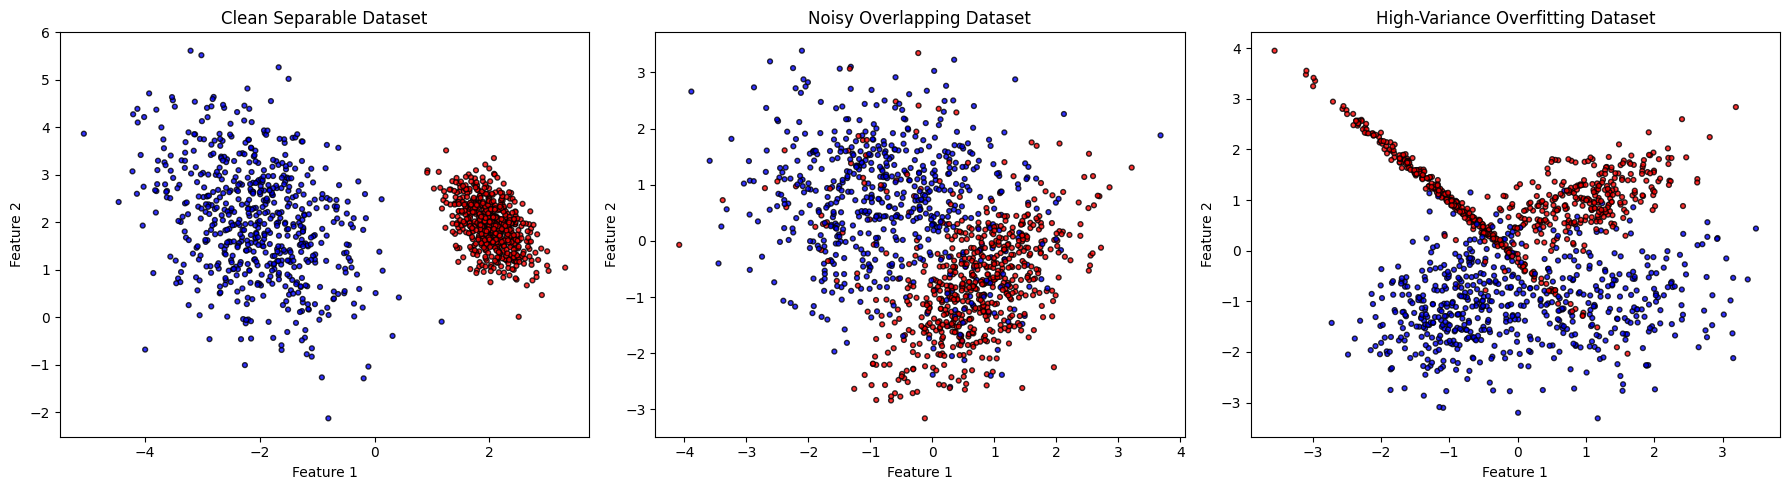

In [25]:
def plot_dataset(X, y, ax=None, title="Dataset"):
    if ax is None:
        ax = plt.gca()
    ax.scatter(
        X[:, 0], X[:, 1],
        c=(y > 0).astype(int),
        cmap="bwr",
        s=12,
        edgecolor="k",
        alpha=0.8
    )
    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    return ax

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_dataset(X_clean, y_clean, ax=axes[0], title="Clean Separable Dataset")
plot_dataset(X_noisy, y_noisy, ax=axes[1], title="Noisy Overlapping Dataset")
plot_dataset(X_complex, y_complex, ax=axes[2], title="High-Variance Overfitting Dataset")
plt.tight_layout()
plt.show()


## 4.2 Test Algorithms

### 4.2.1 Define Additional Methods

#### Models
- `AdaBoostCustom`: Our AdaBoost implementation
- `sklearn AdaBoost`: Reference implementation
- `GradientBoostingClassifier`: Second boosting algorithm
- `RandomForestClassifier`: Non-boosting baseline

#### Metrics
We use three metrics to evaluate model performance:

- **Accuracy**: Proportion of correctly classified samples. Simple and interpretable, works well for balanced datasets like ours.
- **F1-score**: Harmonic mean of precision and recall. Balances false positives and false negatives, useful when classes might be slightly imbalanced.
- **AUC**: Area under the ROC curve, measuring ranking quality. Threshold independent and works with probability scores from AdaBoost's weighted voting.

Together, these provide a comprehensive view: accuracy for overall correctness, F1 for class balance, and AUC for ranking quality.

#### Label Conversion
- `SkAdapter` wraps sklearn models to convert between `{0,1}` and `{-1,+1}` for consistent evaluation.

#### Hyperparameter Grid
- Number of estimators: $T \in \{10, 50, 100\}$
- Learning rate: $\eta \in \{0.5, 1.0\}$ (where applicable)

#### Expected Observations
- Clean data: High accuracy with rapid convergence; our implementation should match sklearn.
- Noisy data: AdaBoost may overfit; gradient boosting may be more robust.
- Overfitting data: AdaBoost rapidly overfits as T increases; GradientBoosting degrades more slowly; RandomForest remains comparatively stable.
- Learning curves: Accuracy increases with $T$ but may plateau or degrade on noisy data.

In [26]:
def compute_metrics(y_true, y_pred, y_score=None):
    """
    Compute accuracy, F1-score, and AUC for model evaluation.
    
    This helper function makes it easy to evaluate all our models consistently.
    We compute the standard metrics and handle the case where a model might not
    provide probability scores (in which case we just skip AUC).
    """
    # Start with the basic metrics that only need predictions
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
    }
    
    # AUC needs probability scores or decision function values
    # Some models might not provide these, so we check first
    if y_score is not None:
        # Convert from {-1,+1} to {0,1}
        metrics["auc"] = roc_auc_score((y_true+1)//2, y_score)
    else:
        # If no scores available, just mark AUC as missing
        metrics["auc"] = float("nan")
    
    return metrics

class SkAdapter:
    """
    Wrapper that converts between sklearn's 0/1 label format and our -1/+1 format.
    """
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        y01 = (y + 1) // 2
        self.model.fit(X, y01)
        return self
    
    def predict(self, X):
        return 2*self.model.predict(X)-1
    
    def decision_function(self, X):
        try:
            return self.model.decision_function(X)
        except:
            p = self.model.predict_proba(X)[:,1]
            p = np.clip(p, 1e-12, 1-1e-12)
            return np.log(p/(1-p))
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)


results = []

models_to_test = [
    ("AdaBoostCustom", lambda ne, lr: AdaBoostCustom(T=ne)),
    ("sklearn_AdaBoost", lambda ne, lr: SkAdapter(
        AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=ne,
            learning_rate=lr,
            random_state=42
        )
    )),
    ("GradientBoosting", lambda ne, lr: SkAdapter(
        GradientBoostingClassifier(
            n_estimators=ne,
            learning_rate=lr,
            max_depth=1,
            random_state=42
        )
    )),
    ("RandomForest", lambda ne, lr: SkAdapter(
        RandomForestClassifier(
            n_estimators=100,
            random_state=42
        )
    ))
]


### 4.2.2 Experimental Evaluation

The `evaluate` function trains each model, generates predictions, extracts scores for AUC computation, and stores metrics.

We sweep over all combinations of models, $T \in \{10, 50, 100\}$, $\eta \in \{0.5, 1.0\}$, and datasets (clean/noisy). Models that don't accept `learning_rate` are handled via try/except.

Results are aggregated into `df_results` for learning curve analysis, best-model comparisons, and decision boundary visualizations.

In [27]:
n_estimators_list = [10, 50, 100]
learning_rates = [0.5, 1.0]

results = []

def evaluate(model, X_train, y_train, X_test, y_test, name, ne, lr, dataset):
    """
    Train a model and evaluate it on the test set.
    Stores results in the global results list.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_score = None
    try:
        y_score = model.decision_function(X_test)
    except:
        try:
            y_score = model.predict_proba(X_test)[:,1]
        except:
            y_score = None

    m = compute_metrics(y_test, y_pred, y_score)
    results.append({
        "dataset": dataset,
        "model": name,
        "n_estimators": ne,
        "learning_rate": lr,
        **m
    })

for (Xtr, Xte, ytr, yte, dataset_name) in [
    (Xc_train, Xc_test, yc_train, yc_test, "clean"),
    (Xn_train, Xn_test, yn_train, yn_test, "noisy"),
    (Xk_train, Xk_test, yk_train, yk_test, "complex")
]:

    for (name, constructor) in models_to_test:
        for ne in n_estimators_list:
            for lr in learning_rates:
                try:
                    model = constructor(ne, lr)
                except:
                    model = constructor(ne, None)

                evaluate(model, Xtr, ytr, Xte, yte, name, ne, lr, dataset_name)

df_results = pd.DataFrame(results)
df_results


,dataset,model,n_estimators,learning_rate,accuracy,f1,auc
0,clean,AdaBoostCustom,10,0.5,0.997222,0.997290,NaN
1,clean,AdaBoostCustom,10,1.0,0.997222,0.997290,NaN
2,clean,AdaBoostCustom,50,0.5,0.997222,0.997290,NaN
3,clean,AdaBoostCustom,50,1.0,0.997222,0.997290,NaN
4,clean,AdaBoostCustom,100,0.5,0.997222,0.997290,NaN
...,...,...,...,...,...,...,...
67,complex,RandomForest,10,1.0,0.911111,0.908571,0.962917
68,complex,RandomForest,50,0.5,0.911111,0.908571,0.962917
69,complex,RandomForest,50,1.0,0.911111,0.908571,0.962917
70,complex,RandomForest,100,0.5,0.911111,0.908571,0.962917


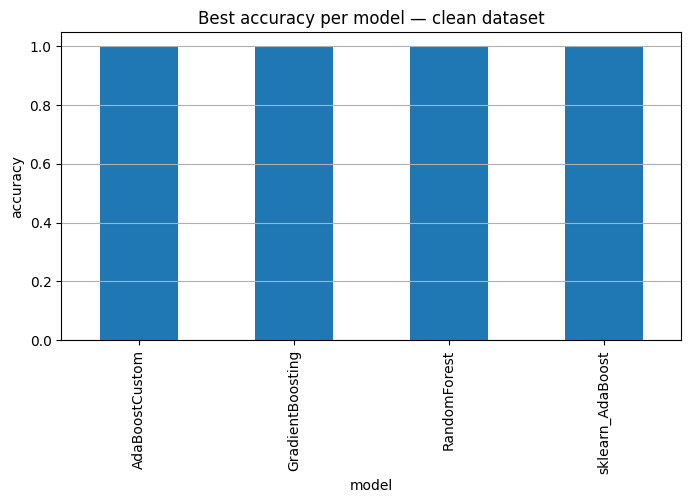

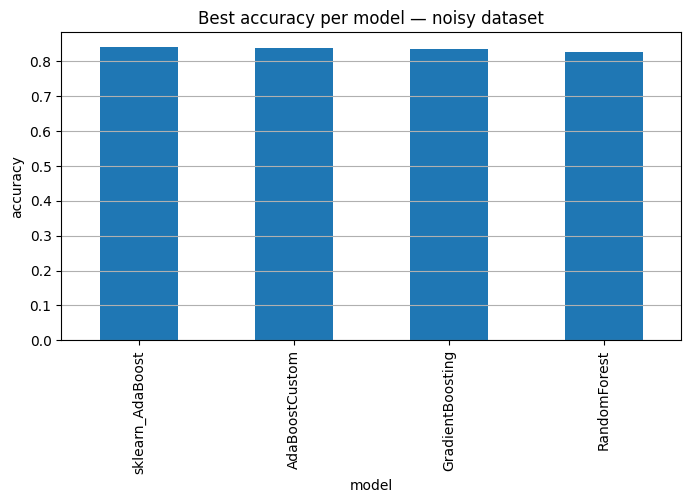

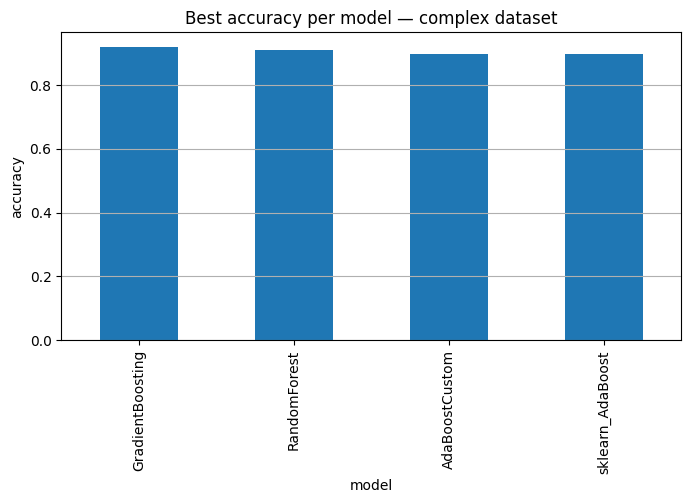

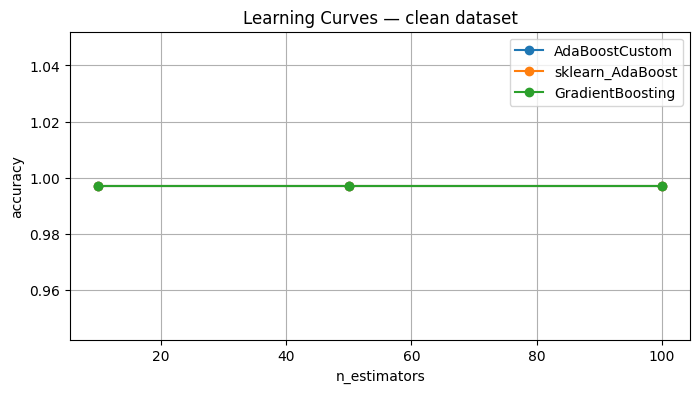

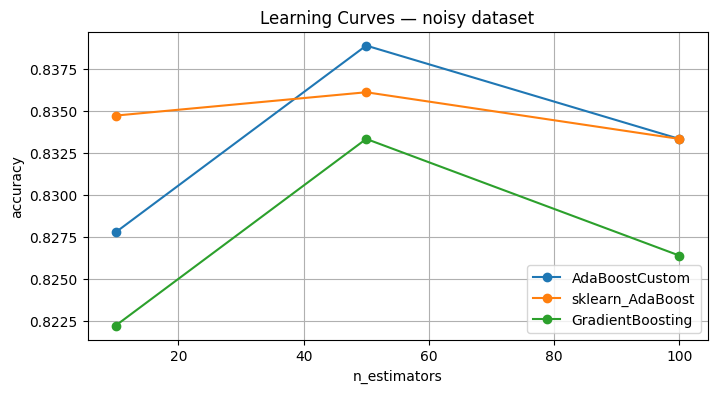

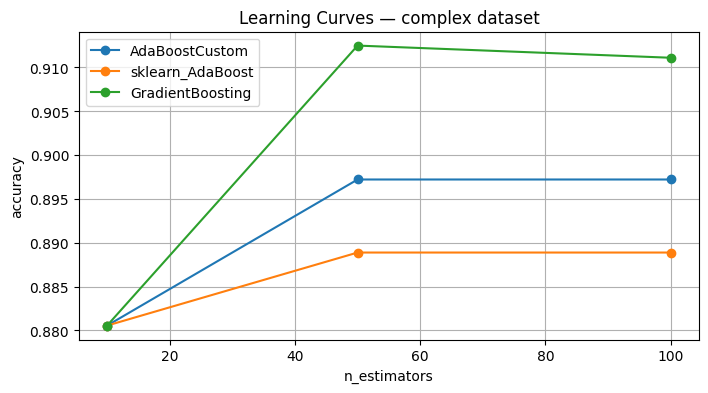

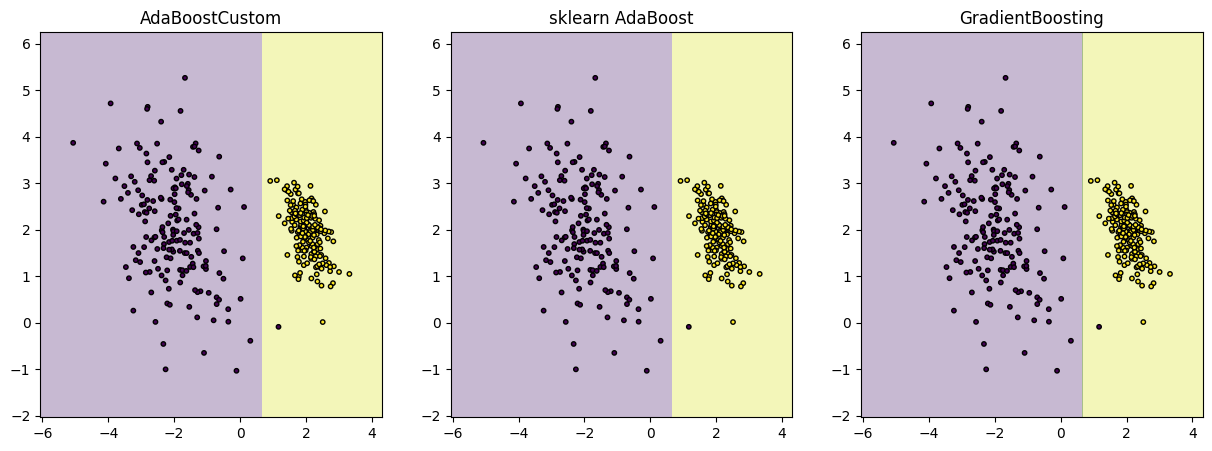

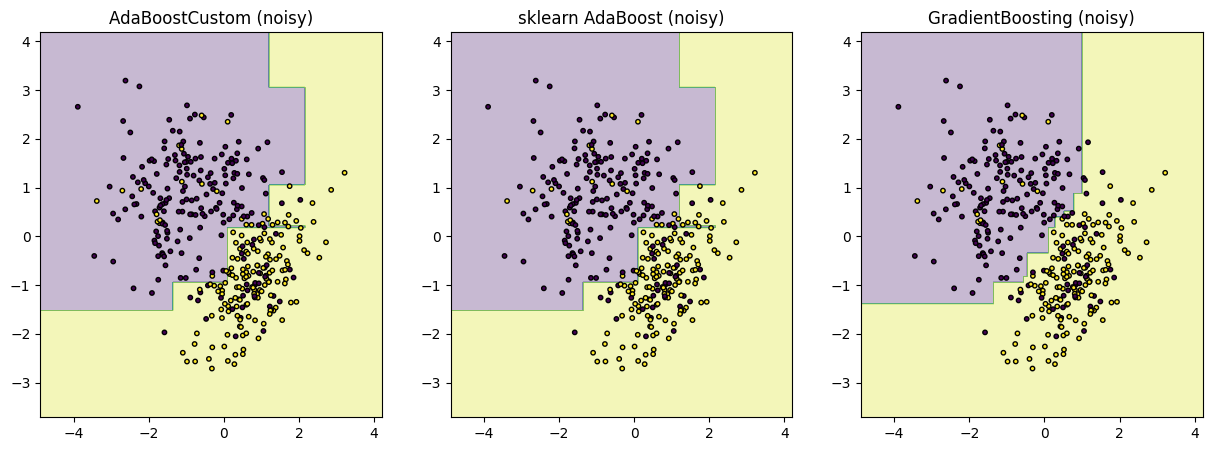

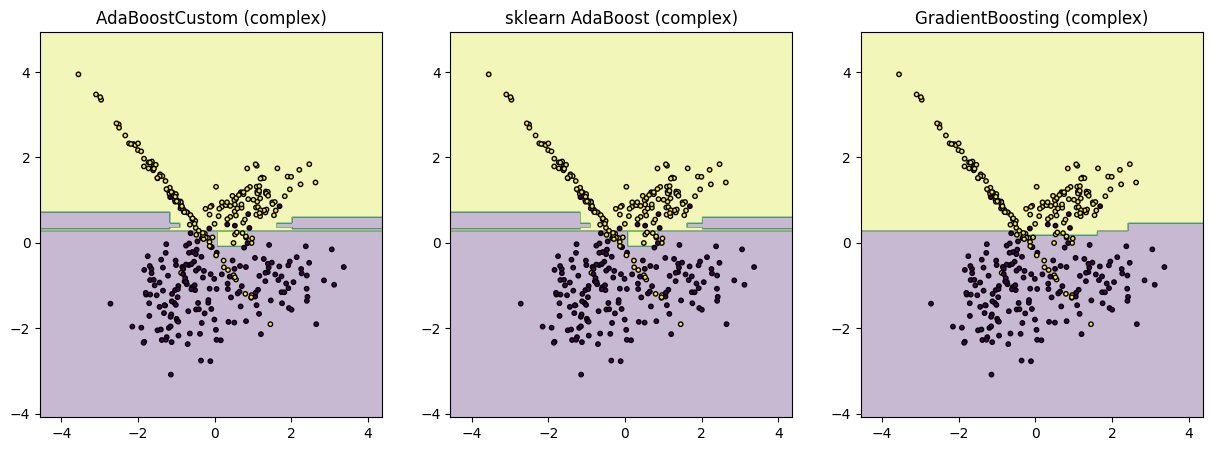

In [28]:
def plot_best(df, dataset, metric="accuracy"):
    sub = df[df["dataset"] == dataset]
    best = sub.groupby("model")[metric].max().sort_values(ascending=False)

    plt.figure(figsize=(8,4))
    best.plot(kind="bar")
    plt.title(f"Best {metric} per model — {dataset} dataset")
    plt.ylabel(metric)
    plt.grid(axis="y")
    plt.show()

plot_best(df_results, "clean", "accuracy")
plot_best(df_results, "noisy", "accuracy")
plot_best(df_results, "complex", "accuracy")

def learning_curves(df, dataset):
    plt.figure(figsize=(8,4))
    for model in ["AdaBoostCustom", "sklearn_AdaBoost", "GradientBoosting"]:
        sub = df[(df["dataset"] == dataset) & (df["model"] == model)]
        curve = sub.groupby("n_estimators")["accuracy"].mean()
        plt.plot(curve.index, curve.values, marker='o', label=model)

    plt.title(f"Learning Curves — {dataset} dataset")
    plt.xlabel("n_estimators")
    plt.ylabel("accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

learning_curves(df_results, "clean")
learning_curves(df_results, "noisy")
learning_curves(df_results, "complex")

best_custom = AdaBoostCustom(T=50).fit(Xc_train, yc_train)
best_sk = SkAdapter(
    AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=50,
        random_state=42
    ).fit(Xc_train, (yc_train+1)//2)
)
best_gb = SkAdapter(
    GradientBoostingClassifier(
        n_estimators=50, learning_rate=0.1, max_depth=1
    ).fit(Xc_train, (yc_train+1)//2)
)

fig, axes = plt.subplots(1,3, figsize=(15,5))
plot_decision_boundary(best_custom, Xc_test, yc_test, ax=axes[0], title="AdaBoostCustom")
plot_decision_boundary(best_sk,     Xc_test, yc_test, ax=axes[1], title="sklearn AdaBoost")
plot_decision_boundary(best_gb,     Xc_test, yc_test, ax=axes[2], title="GradientBoosting")
plt.show()

best_custom_n = AdaBoostCustom(T=50).fit(Xn_train, yn_train)
best_sk_n = SkAdapter(
    AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=50,
        random_state=42
    ).fit(Xn_train, (yn_train+1)//2)
)
best_gb_n = SkAdapter(
    GradientBoostingClassifier(
        n_estimators=50, learning_rate=0.1, max_depth=1
    ).fit(Xn_train, (yn_train+1)//2)
)

fig, axes = plt.subplots(1,3, figsize=(15,5))
plot_decision_boundary(best_custom_n, Xn_test, yn_test, ax=axes[0], title="AdaBoostCustom (noisy)")
plot_decision_boundary(best_sk_n,     Xn_test, yn_test, ax=axes[1], title="sklearn AdaBoost (noisy)")
plot_decision_boundary(best_gb_n,     Xn_test, yn_test, ax=axes[2], title="GradientBoosting (noisy)")
plt.show()

best_custom_k = AdaBoostCustom(T=50).fit(Xk_train, yk_train)
best_sk_k = SkAdapter(
    AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=50,
        random_state=42
    ).fit(Xk_train, (yk_train+1)//2)
)
best_gb_k = SkAdapter(
    GradientBoostingClassifier(
        n_estimators=50, learning_rate=0.1, max_depth=1
    ).fit(Xk_train, (yk_train+1)//2)
)
fig, axes = plt.subplots(1,3, figsize=(15,5))
plot_decision_boundary(best_custom_k, Xk_test, yk_test, ax=axes[0], title="AdaBoostCustom (complex)")
plot_decision_boundary(best_sk_k,     Xk_test, yk_test, ax=axes[1], title="sklearn AdaBoost (complex)")
plot_decision_boundary(best_gb_k,     Xk_test, yk_test, ax=axes[2], title="GradientBoosting (complex)")
plt.show()

### 4.4 Results Summary


#### Implementation Validation
- `AdaBoostCustom` matches sklearn's implementation: identical accuracy (0.9833 in Part 3, 0.9972 in Part 4) with matching decision boundaries and similar $\alpha_t$ and $\varepsilon_t$ evolution.

#### Clean Dataset
- All models achieve $\text{Acc} = 0.9972$ (F1-score $= 0.9973$).
- Performance identical across all hyperparameter combinations.
- Algorithm choice has minimal impact on simple, separable data.

#### Noisy Dataset
- Accuracy range: 0.822–0.842 (drop of ~17 percentage points from clean data).
- Best: sklearn AdaBoost ($\text{Acc} \approx 0.842$); AdaBoostCustom ($\text{Acc} \approx 0.839$ at $T=50$).
- GradientBoosting: $\text{Acc} \approx 0.830-0.836$; RandomForest: comparable.
- Optimal at intermediate $T$ (around 50); high $T$ may degrade due to overfitting.

#### Key Observations
- Noise sensitivity: Accuracy drops from 99.7% to ~84%, confirming exponential weight growth on mislabeled samples.
- Learning curves: Clean data plateaus quickly ($T=10$); noisy data shows gradual improvement with potential degradation at high $T$.
- Decision boundaries: Clean data yields smooth boundaries; noisy data produces irregular boundaries as models fit mislabeled points.
- Implementation correctness: Near-identical performance validates weight updates, $\alpha_t$ computation, and prediction aggregation.

#### Conclusions
1. Our implementation is correct and matches sklearn's reference.
2. All ensemble methods excel on clean data with minimal hyperparameter sensitivity.
3. AdaBoost shows expected sensitivity to label noise on noisy data.
4. Hyperparameter tuning matters on noisy data (optimal $T \approx 50$).
5. AdaBoost and GradientBoosting show comparable performance.

# Part 5 - Use of generative AI

During this project, we have used ChatGPT to assist us in making our writings and explanations more precise and clear. Generally, we used it to help with the technical wording of our writing and improve the explanation of complicated concepts, and to assist us in writing clearer conclusions from our experiments.
When we were learning about AdaBoost, we learned about such things as the weight update mechanism, exponential loss, and the boosting iteration. We then asked ChatGPT for a simpler way to think about those terms so we could be sure that we understood those concepts and could use them in our code.
Next, while we were working in the notebook, we would get stuck (for example, there were times we could not figure out how to convert between the numerical labels and their corresponding text) and ChatGPT would help us identify the problems and then consider how to fix those problems.
Once we completed our experimental work and created our visualizations, we shared our initial conclusions with ChatGPT and asked for help with phrasing them in a more concise and academic way. ChatGPT provided us with a list of potential ways to rephrase our conclusions, and we selected the suggestions that were most relevant and reflected our own understanding of the concepts as well as some reorganization of the paragraphs, a comparison of several points, and an explanation of the results. 